In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

**Observations for data cleaning**

1. Lot of column names have '.' in the name. Need to replace it with '_'
2. Most of the categorical variables have data type of int insted of object/category
3. Date of birth, disbursal date etc. does not have date data type. Need to change the datatype.
4. Account age and Credit history columns have dates, need to convert it to number of days
5. Need to calculate customer age from Date of birth
6. Looking at df.info(), only Employment Type has null values


# Data Cleaning

In [4]:
#Renaming Column names
#Repalcing '.' with '_' in the column names

columns = df.columns.to_list()

for i in range(len(columns)):
    if '.' in columns[i]:
        columns[i] = columns[i].replace('.','_')


old_columns = df.columns.to_list()
new_columns = {old_columns[i]: columns[i] for i in range(len(old_columns))}
df.rename(new_columns,axis= 1,inplace = True)

In [5]:
#Dropping unnecessary columns 

df.drop(columns= ['UniqueID','supplier_id','Current_pincode_ID','Employee_code_ID',
                  'MobileNo_Avl_Flag','DisbursalDate', 'PERFORM_CNS_SCORE_DESCRIPTION'],
        axis = 1, inplace = True)

In [6]:
#Datatype of branchID,manufacturerID, StateID etc. are given as Int, 
#need to convert them to object datatype

Categorical_data = ['loan_default','branch_id','manufacturer_id','Employment_Type'
                    ,'State_ID',]
df[Categorical_data] = df[Categorical_data].astype(object)

In [7]:
#Converting Object data type to appropriate date format

df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'])

#Getting the age of the customer from Date of birth

def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df['Age'] = df['Date_of_Birth'].apply(lambda x: from_dob_to_age(x))
df.drop(columns=['Date_of_Birth'],axis=1,inplace= True)

In [8]:
#Changing AVERAGE_ACCT_AGE in total months values

years1 = df.AVERAGE_ACCT_AGE.str.split(" ").str[0].str.split("y").str[0]
months1 = df.AVERAGE_ACCT_AGE.str.split(" ").str[1].str.split("m").str[0]
years1 = np.array(years1).astype(int)
months1 = np.array(months1).astype(int)
df.AVERAGE_ACCT_AGE = years1*12 + months1

In [9]:
#Changing CREDIT_HISTORY_LENGTH in total months values

years2 = df.CREDIT_HISTORY_LENGTH.str.split(" ").str[0].str.split("y").str[0]
months2 = df.CREDIT_HISTORY_LENGTH.str.split(" ").str[1].str.split("m").str[0]
years2 = np.array(years2).astype(int)
months2 = np.array(months2).astype(int)
df.CREDIT_HISTORY_LENGTH = years2*12 + months2

In [10]:
#Handling null values in Employment type

df.Employment_Type.unique()

array(['Salaried', 'Self employed', nan], dtype=object)

In [11]:
df.Employment_Type.describe()

count            225493
unique                2
top       Self employed
freq             127635
Name: Employment_Type, dtype: object

In [12]:
df['Employment_Type'].fillna(df['Employment_Type'].mode()[0], inplace= True)

In [13]:
print('''Unique value in all the categorical variables:
        ''')
for i in range(len(Categorical_data)):
    if i > 0:
        Value = len(df[Categorical_data[i]].unique())
        print(f"{Categorical_data[i]} - {Value}")

Unique value in all the categorical variables:
        
branch_id - 82
manufacturer_id - 11
Employment_Type - 2
State_ID - 22


# Exploratory Data Analysis

### How is the target variable distributed overall?

In [14]:
df_defaulted = df[df['loan_default'] == 1]
df_normal = df[df['loan_default'] == 0]

In [15]:
print(df_defaulted.shape,df_normal.shape)

(50611, 34) (182543, 34)


In [16]:
50611/233154*100

21.70711203753742

**Target varible has distribution of approximately 80-20. We will have to balance the dataset before model building.**

## Branch / State / Manufacturer wise distribution of defaulters

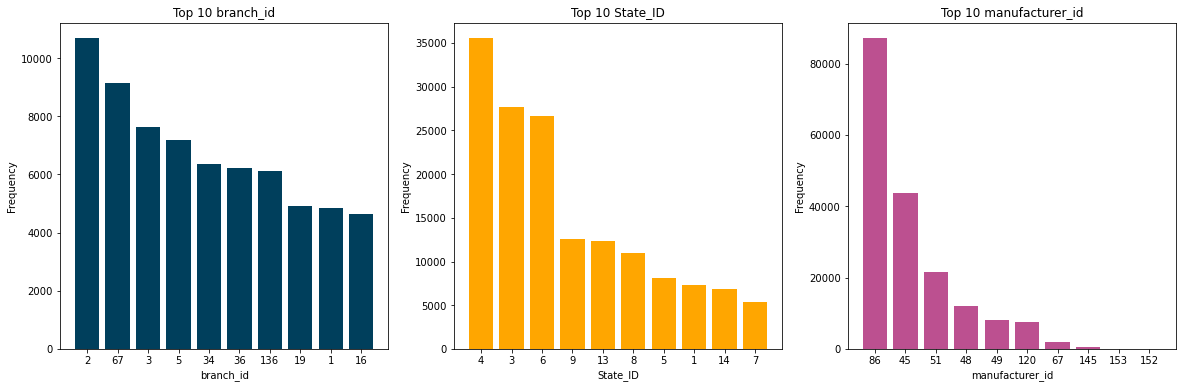

In [17]:
cate = ['branch_id','State_ID','manufacturer_id']
colors= ['#003f5c','#ffa600','#bc5090']
plt.figure(figsize= (20,6))


for i, column in enumerate(cate, 1):
    plt.subplot(1, 3, i)
    plt.bar(df[df['loan_default'] == 0][column].value_counts().head(10).index.astype(str),
            df[df['loan_default'] == 0][column].value_counts().head(10),color= colors[i-1])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('Top 10 '+column)

    

## Employment type wise distribution of defaulters

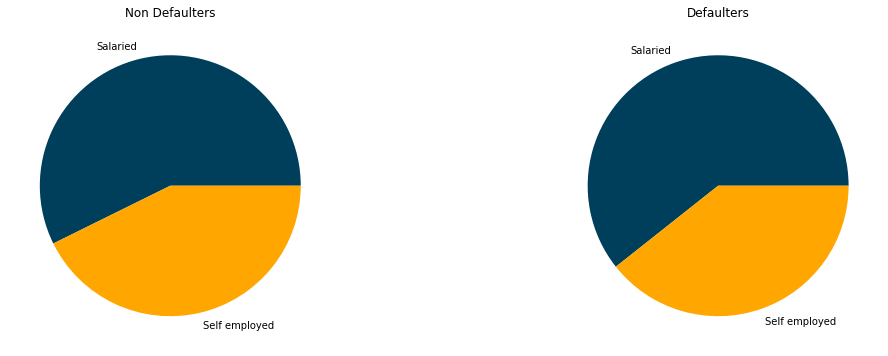

In [18]:
labels = ['Salaried', 'Self employed']
plt.figure(figsize= (18,6));
plt.subplot(1,2,1);
plt.pie(df[df['loan_default'] == 0]['Employment_Type'].value_counts(),labels= labels, colors= ['#003f5c','#ffa600']);
plt.title('Non Defaulters');
plt.subplot(1,2,2);
plt.pie(df[df['loan_default'] == 1]['Employment_Type'].value_counts(),labels= labels, colors= ['#003f5c','#ffa600']);
plt.title('Defaulters');

For both defaulter and non defaulter, the distribution looks the same. This does not provide any meaningful insight.

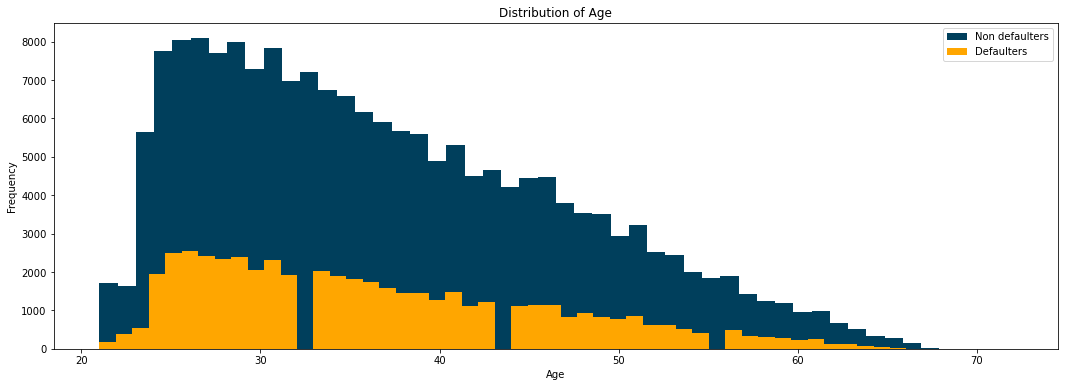

In [19]:
plt.figure(figsize= (18,6));
plt.hist(df[df['loan_default']==0]['Age'], bins= 50,color='#003f5c');
plt.hist(df[df['loan_default']==1]['Age'], bins= 50,color='#ffa600');
labels_ = ['Non defaulters','Defaulters']
plt.legend(labels_);
plt.xlabel('Age');
plt.ylabel('Frequency');
plt.title('Distribution of Age');


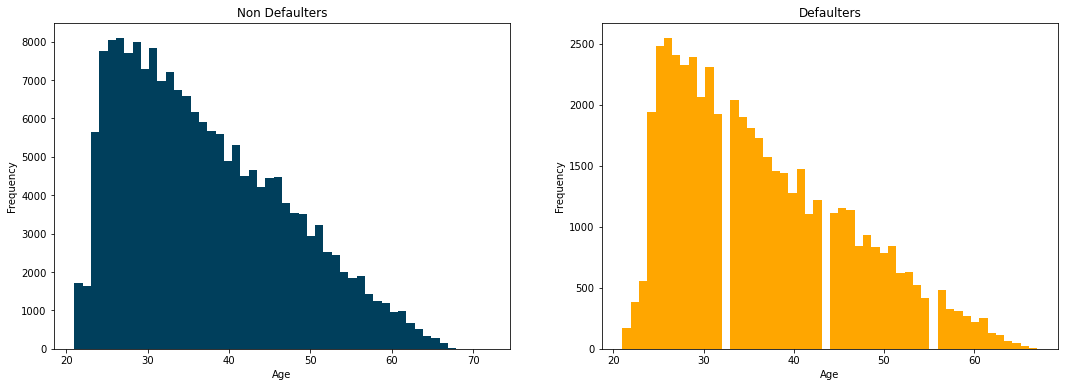

In [20]:
plt.figure(figsize= (18,6))
plt.subplot(1,2,1);
plt.hist(df[df['loan_default']==0]['Age'], bins= 50, color='#003f5c');
plt.title('Non Defaulters');
plt.xlabel('Age');
plt.ylabel('Frequency');
plt.subplot(1,2,2);
plt.hist(df[df['loan_default']==1]['Age'], bins= 50,color= '#ffa600');
plt.title('Defaulters');
plt.xlabel('Age');
plt.ylabel('Frequency');

In both cases the distribution looks the same. Age group 25-35 looks the most borrower and it is the same group that has defaulted the most. 

In [21]:
#What types of IDs were presented

flags = ['Aadhar_flag','VoterID_flag','PAN_flag']
print('''Types of IDs given in defaulted cases:
        
            Defaulters      Non defaulters''')
for i in range(len(flags)):
    Value1 = sum(df_defaulted[flags[i]])
    Value2 = sum(df_normal[flags[i]])
    
    print(f"{flags[i]}       {Value1}      {Value2}")

Types of IDs given in defaulted cases:
        
            Defaulters      Non defaulters
Aadhar_flag       41065      154859
VoterID_flag       8816      24978
PAN_flag       3877      13744


# Description of the quantitative data variables

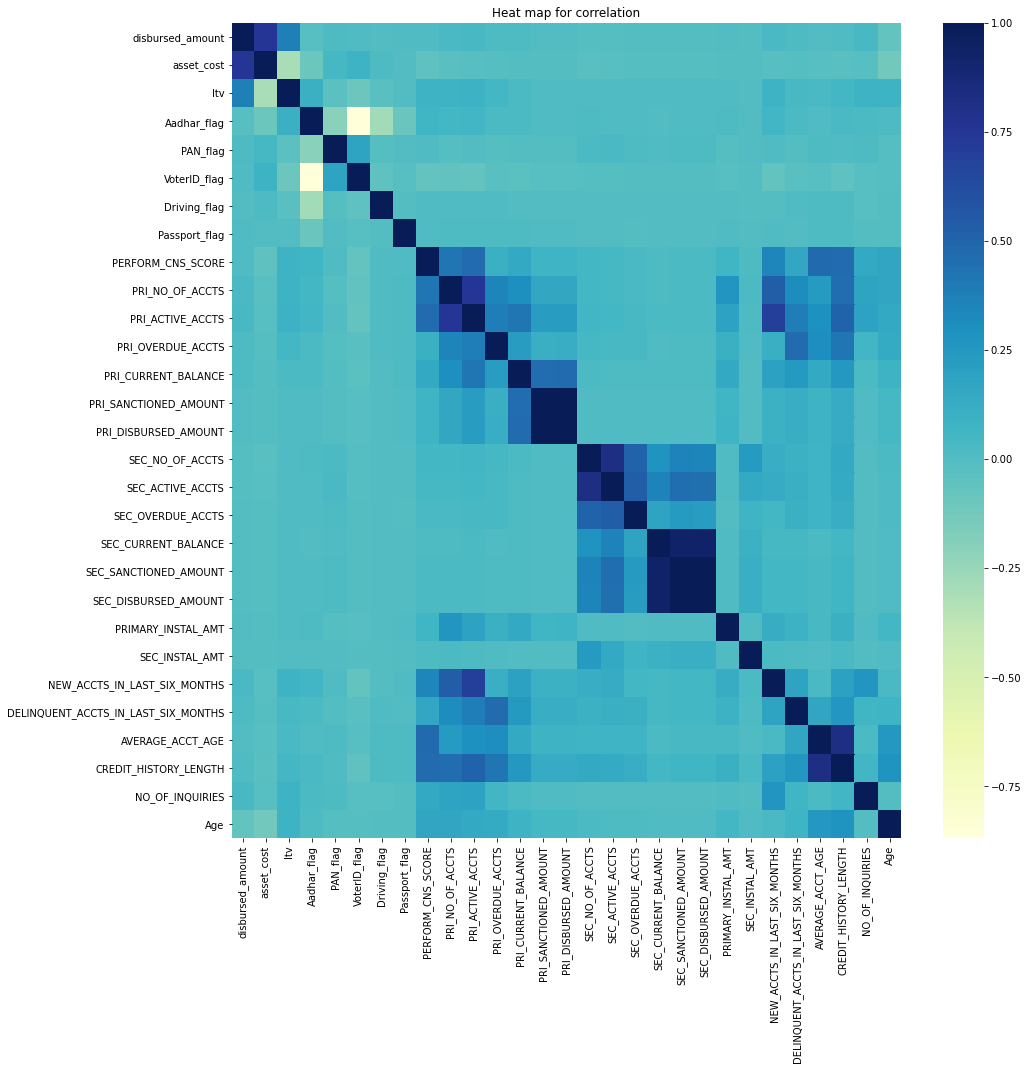

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(df.corr(),cmap="YlGnBu");
plt.title('Heat map for correlation');

In [23]:
quantative_data = ['disbursed_amount', 'asset_cost', 'ltv','PERFORM_CNS_SCORE','Age']

In [24]:
df[quantative_data].describe()

,disbursed_amount,asset_cost,ltv,PERFORM_CNS_SCORE,Age
count,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000
mean,54356.993528,7.586507e+04,74.746530,289.462994,37.088204
std,12971.314171,1.894478e+04,11.456636,338.374779,9.806811
min,13320.000000,3.700000e+04,10.030000,0.000000,21.000000
25%,47145.000000,6.571700e+04,68.880000,0.000000,29.000000
50%,53803.000000,7.094600e+04,76.800000,0.000000,35.000000
75%,60413.000000,7.920175e+04,83.670000,678.000000,44.000000
max,990572.000000,1.628992e+06,95.000000,890.000000,72.000000


In [25]:
df_normal[quantative_data].describe()

,disbursed_amount,asset_cost,ltv,PERFORM_CNS_SCORE,Age
count,182543.000000,1.825430e+05,182543.000000,182543.000000,182543.000000
mean,53826.471111,7.572281e+04,74.154093,299.784270,37.280482
std,13140.699007,1.901500e+04,11.681455,342.883794,9.838486
min,13320.000000,3.700000e+04,10.030000,0.000000,21.000000
25%,46369.000000,6.568000e+04,68.020000,0.000000,29.000000
50%,53303.000000,7.084500e+04,76.000000,15.000000,36.000000
75%,59947.000000,7.899900e+04,83.160000,690.000000,44.000000
max,990572.000000,1.628992e+06,95.000000,890.000000,72.000000


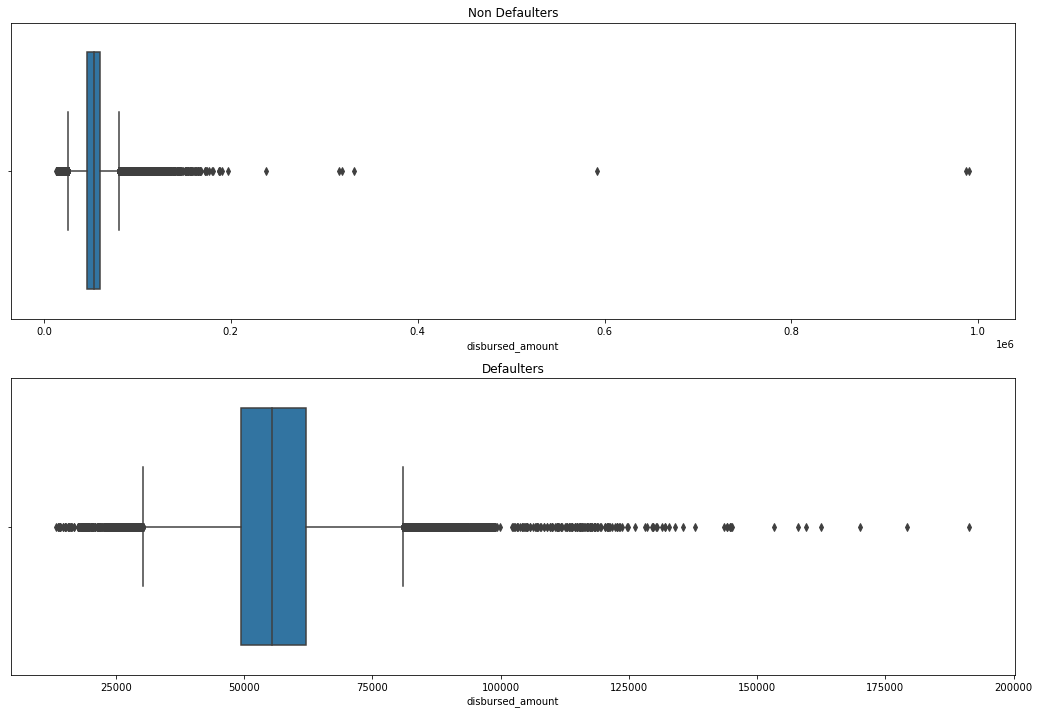

In [26]:
#Disbursed amount

plt.figure(figsize= (18,12))
plt.subplot(2,1,1);
plt.title('Non Defaulters');
sns.boxplot(df[df['loan_default']==0]['disbursed_amount']);

plt.subplot(2,1,2);
plt.title('Defaulters');
sns.boxplot(df[df['loan_default']==1]['disbursed_amount']);


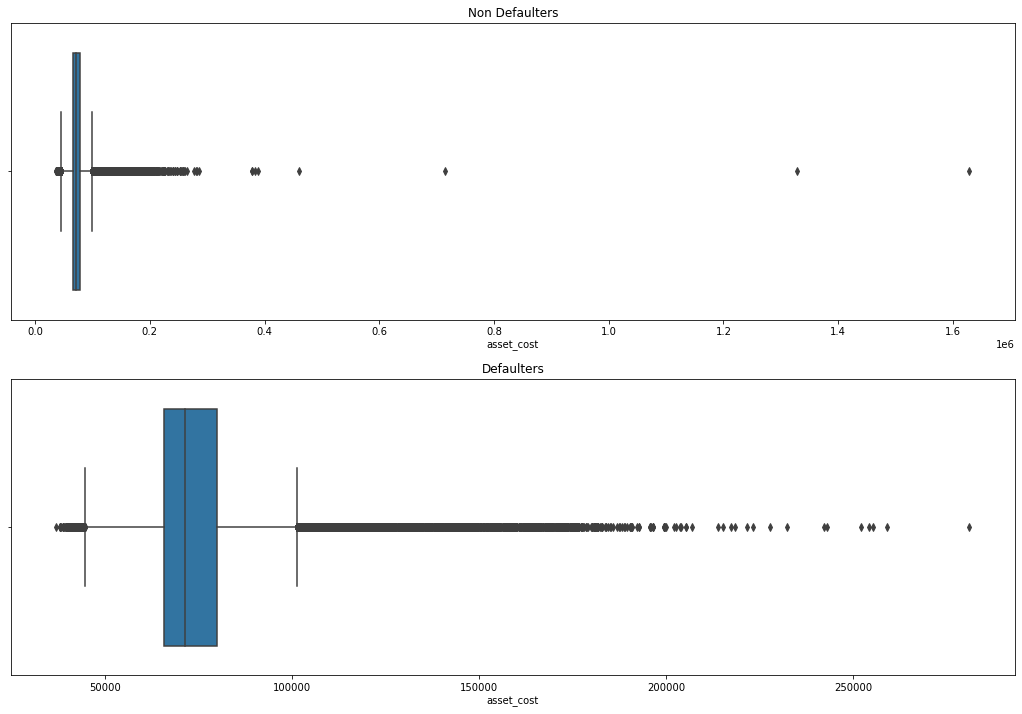

In [27]:
#Asset cost

plt.figure(figsize= (18,12))
plt.subplot(2,1,1);
sns.boxplot(df[df['loan_default']==0]['asset_cost']);
plt.title('Non Defaulters');
plt.subplot(2,1,2);
sns.boxplot(df[df['loan_default']==1]['asset_cost']);
plt.title('Defaulters');

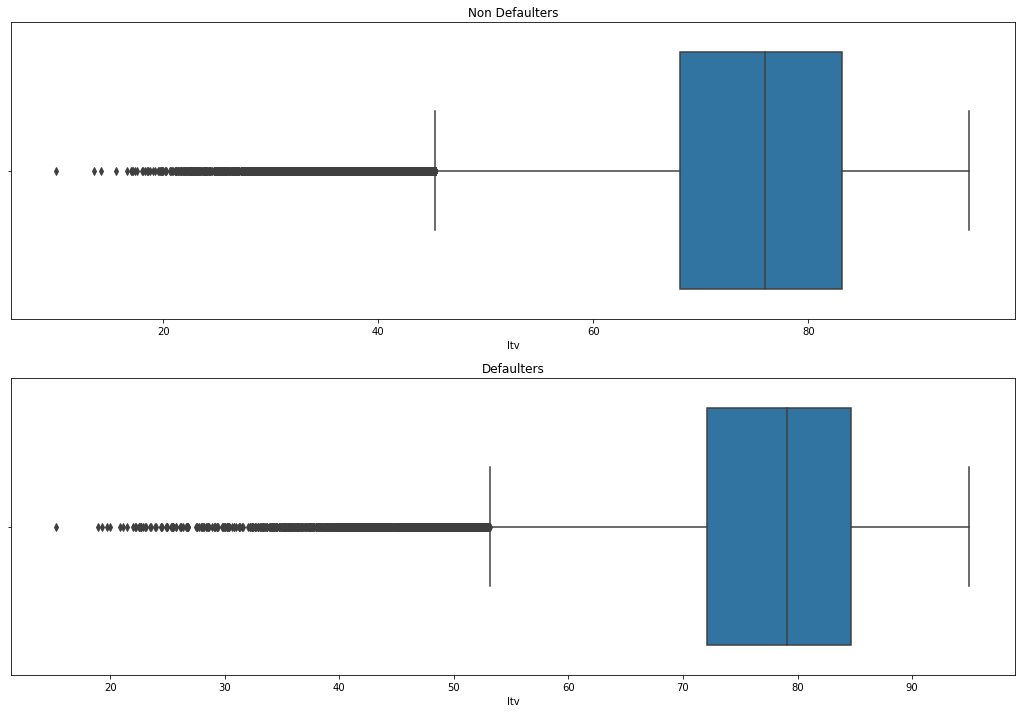

In [28]:
#ltv

plt.figure(figsize= (18,12))
plt.subplot(2,1,1);
sns.boxplot(df[df['loan_default']==0]['ltv']);
plt.title('Non Defaulters');
plt.subplot(2,1,2);
sns.boxplot(df[df['loan_default']==1]['ltv']);
plt.title('Defaulters');

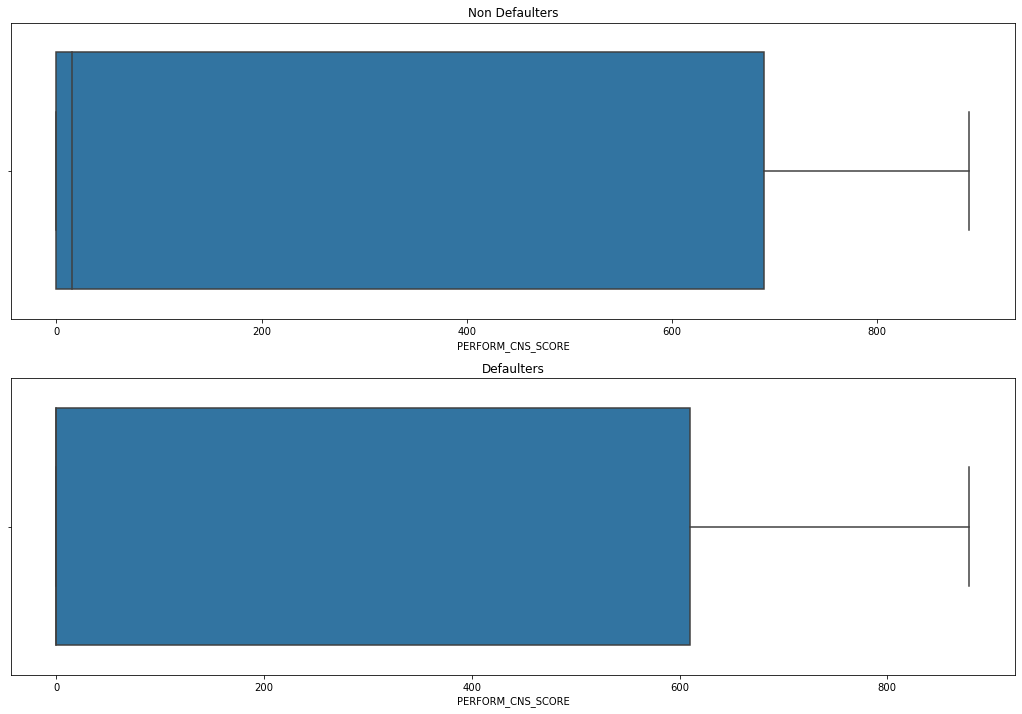

In [29]:
#PERFORM CNS SCORE

plt.figure(figsize= (18,12))
plt.subplot(2,1,1);
sns.boxplot(df[df['loan_default']==0]['PERFORM_CNS_SCORE']);
plt.title('Non Defaulters');
plt.subplot(2,1,2);
sns.boxplot(df[df['loan_default']==1]['PERFORM_CNS_SCORE']);
plt.title('Defaulters');

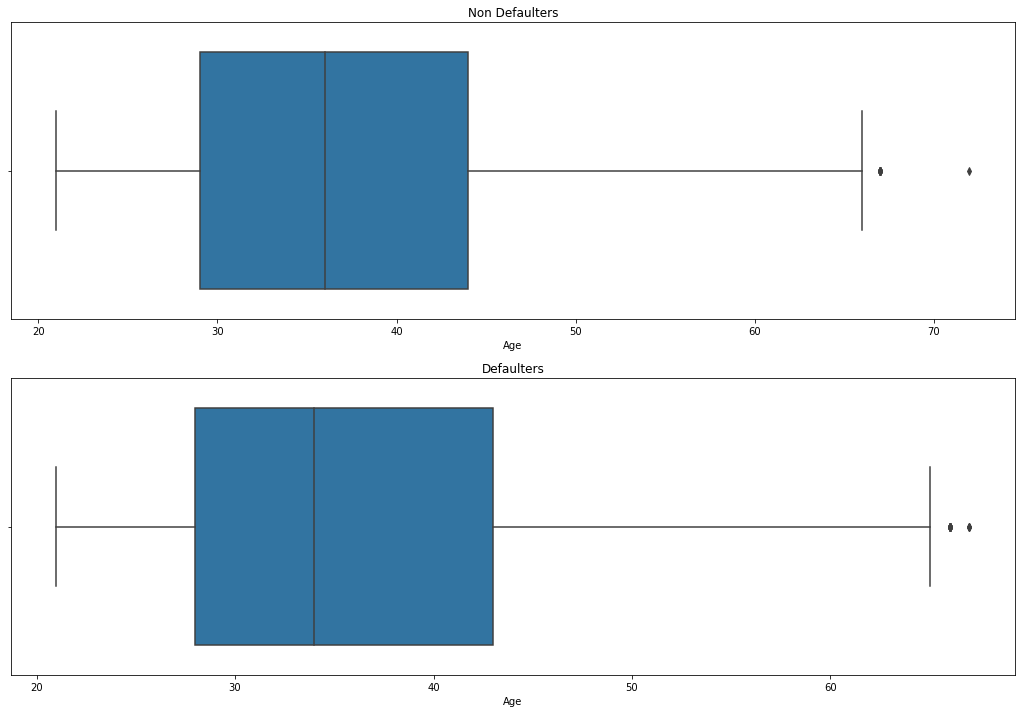

In [30]:
#Age

plt.figure(figsize= (18,12))
plt.subplot(2,1,1);
sns.boxplot(df[df['loan_default']==0]['Age']);
plt.title('Non Defaulters');
plt.subplot(2,1,2);
sns.boxplot(df[df['loan_default']==1]['Age']);
plt.title('Defaulters');

# Looking at account details

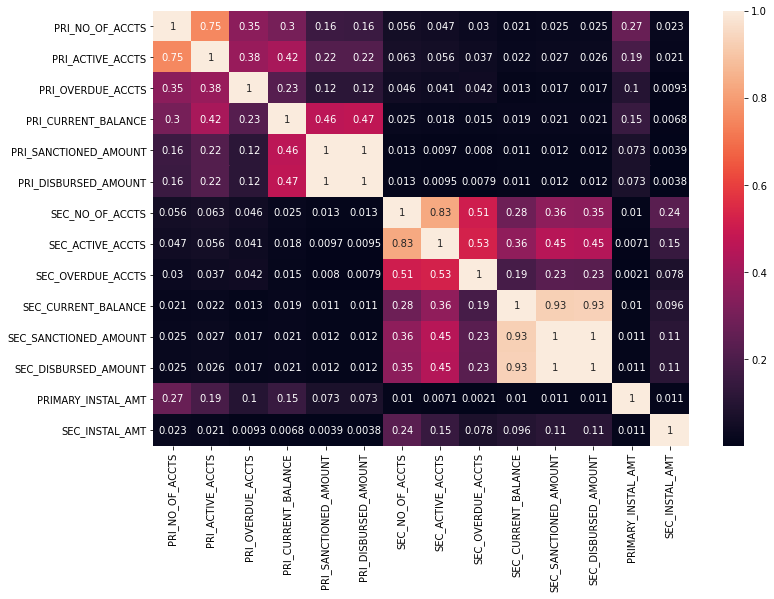

In [31]:
# Checking the correlation between primary and secondary accounts
plt.figure(figsize=(12,8))
sns.heatmap(df[['PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS','PRI_CURRENT_BALANCE',
                'PRI_SANCTIONED_AMOUNT','PRI_DISBURSED_AMOUNT','SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
                'SEC_OVERDUE_ACCTS','SEC_CURRENT_BALANCE','SEC_SANCTIONED_AMOUNT',
                'SEC_DISBURSED_AMOUNT','PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', ]].corr(),annot=True)
plt.show()

From the heat map we can see that secondary account details does not have much high correlation with primary accounts. But we can not negelate the secondary accounts. For ease of operating, we should combine both the fields.

In [32]:
#Combining Primary and Sec accounts

df['NO_OF_ACCTS'] = df['PRI_NO_OF_ACCTS'] + df['SEC_NO_OF_ACCTS']
df['ACTIVE_ACCTS'] = df['PRI_ACTIVE_ACCTS'] + df['SEC_ACTIVE_ACCTS']
df['OVERDUE_ACCTS'] = df['PRI_OVERDUE_ACCTS'] + df['SEC_OVERDUE_ACCTS']
df['CURRENT_BALANCE'] = df['PRI_CURRENT_BALANCE'] + df['SEC_CURRENT_BALANCE']
df['SANCTIONED_AMOUNT'] = df['PRI_SANCTIONED_AMOUNT'] + df['SEC_SANCTIONED_AMOUNT']
df['DISBURSED_AMOUNT'] = df['PRI_DISBURSED_AMOUNT'] + df['SEC_DISBURSED_AMOUNT']
df['INSTAL_AMT'] = df['PRIMARY_INSTAL_AMT'] + df['SEC_INSTAL_AMT']

df.drop(columns = ['PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                   'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT','PRI_DISBURSED_AMOUNT',
                   'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS','SEC_CURRENT_BALANCE',
                'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT','PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT'],
        inplace= True, axis = 1)


In [33]:
acc_details = ['NO_OF_ACCTS','ACTIVE_ACCTS','OVERDUE_ACCTS','CURRENT_BALANCE',
      'SANCTIONED_AMOUNT','DISBURSED_AMOUNT','INSTAL_AMT']

### Non defaulters

In [34]:
df[df['loan_default'] == 0][acc_details].describe()

,NO_OF_ACCTS,ACTIVE_ACCTS,OVERDUE_ACCTS,CURRENT_BALANCE,SANCTIONED_AMOUNT,DISBURSED_AMOUNT,INSTAL_AMT
count,182543.000000,182543.000000,182543.000000,1.825430e+05,1.825430e+05,1.825430e+05,1.825430e+05
mean,2.599886,1.110971,0.152063,1.854112e+05,2.405482e+05,2.398133e+05,1.428754e+04
std,5.338380,2.051149,0.547825,1.014777e+06,1.253845e+06,1.259477e+06,1.590198e+05
min,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.000000,1.000000,0.000000,4.052250e+04,7.270350e+04,7.000000e+04,2.125000e+03
max,354.000000,144.000000,25.000000,9.652492e+07,1.058657e+08,1.057557e+08,2.564281e+07


### Defaulters 

In [35]:
df[df['loan_default'] == 1][acc_details].describe()

,NO_OF_ACCTS,ACTIVE_ACCTS,OVERDUE_ACCTS,CURRENT_BALANCE,SANCTIONED_AMOUNT,DISBURSED_AMOUNT,INSTAL_AMT
count,50611.000000,50611.000000,50611.000000,5.061100e+04,5.061100e+04,5.061100e+04,5.061100e+04
mean,2.138428,0.911166,0.206101,1.205323e+05,1.726052e+05,1.727044e+05,1.033127e+04
std,5.094236,1.712724,0.618799,7.314120e+05,4.528697e+06,4.530040e+06,1.252350e+05
min,0.000000,0.000000,0.000000,-2.013721e+06,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,1.000000,0.000000,2.729800e+04,5.019300e+04,5.000000e+04,1.930000e+03
max,453.000000,35.000000,18.000000,4.505116e+07,1.000000e+09,1.000000e+09,1.542041e+07


# Model building

 **Count freq encoding in branch_id,man_if, state_id & one hot encoding for employment type**

In [36]:
ohe_list = ['branch_id','manufacturer_id','State_ID']

In [37]:
top_10_list = []
for item in ohe_list:
    y = [x for x in df[item].value_counts().sort_values(ascending= False).head(10).index]
    top_10_list.append(y)

In [38]:
top_10_branch_id = top_10_list[0]
top_10_manufacturer_id = top_10_list[1]
top_10_State_ID = top_10_list[2]

In [39]:
def one_hot_encoding(df, variable, top_10_lables):
    for lable in top_10_lables:
        df[variable+'_'+str(lable)] = np.where(df[variable] == lable, 1, 0)
        
one_hot_encoding(df,'branch_id',top_10_branch_id)
one_hot_encoding(df,'manufacturer_id',top_10_manufacturer_id)
one_hot_encoding(df,'State_ID',top_10_State_ID)

df.head()

,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment_Type,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,...,State_ID_4,State_ID_3,State_ID_6,State_ID_13,State_ID_9,State_ID_8,State_ID_5,State_ID_14,State_ID_1,State_ID_7
0,50578,58400,89.55,67,45,Salaried,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,53278,61360,89.63,67,45,Self employed,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,52378,60300,88.39,67,45,Self employed,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,46349,61500,76.42,67,45,Salaried,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,43594,78256,57.50,67,86,Self employed,6,1,0,0,...,0,0,1,0,0,0,0,0,0,0


## Handling Employment type with dummies method 

In [40]:
dummies = pd.get_dummies(df.Employment_Type)

In [41]:
df = pd.concat([df,dummies], axis = 'columns')

## Dropping original columns  

In [42]:
df.drop(columns=['branch_id','manufacturer_id','State_ID','Employment_Type'],
        axis= 1, inplace= True)

# Test train dataset split 

In [43]:
from imblearn.under_sampling import RandomUnderSampler

In [44]:
us = RandomUnderSampler(sampling_strategy=1, random_state=0)

In [45]:
X = df.drop(columns = 'loan_default')
Y = df['loan_default']

In [46]:
Y = Y.astype(int)

In [47]:
x,y = us.fit_resample(X,Y)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=.30)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [50]:
def score_output(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("===================================== Train Result:==============================================\n")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("________________________________________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("________________________________________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("====================================== Test Result:==============================================\n")       
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("________________________________________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("________________________________________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [51]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, Y_train)

score_output(lr_clf, X_train, Y_train, X_test, Y_test, train=True)
score_output(lr_clf, X_train, Y_train, X_test, Y_test, train=False)

===================================== Train Result:==============================================

Accuracy Score: 56.65%
________________________________________________________________________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.577691      0.558036  0.566509      0.567864      0.567873
recall         0.497589      0.635560  0.566509      0.566574      0.566509
f1-score       0.534656      0.594280  0.566509      0.564468      0.564440
support    35461.000000  35394.000000  0.566509  70855.000000  70855.000000
________________________________________________________________________________________________________
Confusion Matrix: 
 [[17645 17816]
 [12899 22495]]

====================================== Test Result:==============================================

Accuracy Score: 56.37%
___________________________________________________________________________________________

In [52]:
rf_clf = RandomForestClassifier(n_estimators=15, max_depth=50, max_features=12, min_samples_leaf=100, random_state=42)
rf_clf.fit(X_train,Y_train)
score_output(rf_clf, X_train, Y_train, X_test, Y_test, train=True)
score_output(rf_clf, X_train, Y_train, X_test, Y_test, train=False)

===================================== Train Result:==============================================

Accuracy Score: 62.52%
________________________________________________________________________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.636161      0.615842  0.625221      0.626002      0.626011
recall         0.586701      0.663813  0.625221      0.625257      0.625221
f1-score       0.610431      0.638929  0.625221      0.624680      0.624666
support    35461.000000  35394.000000  0.625221  70855.000000  70855.000000
________________________________________________________________________________________________________
Confusion Matrix: 
 [[20805 14656]
 [11899 23495]]

====================================== Test Result:==============================================

Accuracy Score: 60.14%
___________________________________________________________________________________________

In [53]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)

score_output(knn_clf, X_train, Y_train, X_test, Y_test, train=True)
score_output(knn_clf, X_train, Y_train, X_test, Y_test, train=False)

===================================== Train Result:==============================================

Accuracy Score: 70.42%
________________________________________________________________________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.706686      0.701677  0.704156      0.704181      0.704184
recall         0.698993      0.709329  0.704156      0.704161      0.704156
f1-score       0.702818      0.705482  0.704156      0.704150      0.704149
support    35461.000000  35394.000000  0.704156  70855.000000  70855.000000
________________________________________________________________________________________________________
Confusion Matrix: 
 [[24787 10674]
 [10288 25106]]

====================================== Test Result:==============================================

Accuracy Score: 53.25%
___________________________________________________________________________________________